In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import os, random

In [2]:
# # Forbidden GPUs
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# set gpus memory used by growth
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


![ESPCN架构](../docs/ESPCN/stru.png)

In this place, $r$ represents the scaling ratio, eg. the input shape of LR is $a * a$ and output shape of HR is $ar * ar$

此处，$r$为放大倍数，如LR输入的shape为$a * a$，则输出shape为$ar * ar$

![detailed image](../docs/ESPCN/net_arch.png)

Processing Flow: Input (LR) -> 5x5 conv -> 3x3 conv -> 3x3 conv -> $r^2$ channels, the channel shape is $a * a$ -> reshape to $ar * ar$ (HR)

处理流程：LR输入 -> 5x5像素卷积 -> 3x3像素卷积 -> 3x3像素卷积 -> $r^2$个channel，每个channel的shape为$a * a$ -> reshape为$ar * ar$

In [3]:
# Old version
# class PixelShuffler(tf.keras.layers.Layer):
#     def __init__(self, target_shape, **kwargs):
#         super(PixelShuffler, self).__init__(**kwargs)
#         self.target_shape = tuple(target_shape)
#         print("init succeed.")
    
#     def build(self,input_shape):
#         # self.inshape = input_shape
#         print("build succeed.")

#     def call(self, inputs,color=True):
#         bsize,inh,inw,ind = inputs.shape
#         if bsize is None:
#                 bsize = -1
#         h,w,d = self.target_shape
#         if ((h%inh!=0) or (w%inw!=0) or (ind%d!=0) or ((h/inh)!=(w/inw)) or ((h/inh)*(w/inw)!=(ind/d))):
#             raise Exception("Error! The shape of input and target is not corresponded.")
#         r = int(h/inh)
#         result = []
#         if color:
#             Xc = tf.split(inputs, 3, 3)
#             for x in Xc:
#                 X = tf.reshape(x, (bsize, inh, inw, r, r))
#                 X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
#                 X = tf.split(X, inh, 1)  # a, [bsize, b, r, r]
#                 X = tf.concat([tf.squeeze(x) for x in X],2)  # bsize, b, a*r, r
#                 X = tf.split(X, inw, 1)  # b, [bsize, a*r, r]
#                 X = tf.concat([tf.squeeze(x) for x in X],2)  # bsize, a*r, b*r
#                 X = tf.reshape(X, (bsize, inh*r, inw*r, 1))
#                 result.append(X)
#             X = tf.concat(result,3)
#         else:
#             X = tf.reshape(inputs, (bsize, inh, inw, r, r))
#             X = tf.transpose(X, (0, 1, 2, 4, 3))  # bsize, a, b, 1, 1
#             X = tf.split(X, 1, inh)  # a, [bsize, b, r, r]
#             X = tf.concat([tf.squeeze(x) for x in X],2)  # bsize, b, a*r, r
#             X = tf.split(X, 1, inw)  # b, [bsize, a*r, r]
#             X = tf.concat([tf.squeeze(x) for x in X],2)  # bsize, a*r, b*r
#             X = tf.reshape(X, (bsize, inh*r, inw*r, 1))
#             X = tf.concat(result,3)
#         print("PixelShuffle Finished.")
#         return X

# model = tf.keras.Sequential()
# # Feature extracting
# model.add(tf.keras.layers.Conv2D(64, 5, activation='relu', padding="same", input_shape=(360, 780, 3)))
# assert model.output_shape == (None, 360, 780, 64)
# model.add(tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"))
# assert model.output_shape == (None, 360, 780, 32)
# model.add(tf.keras.layers.Conv2D(12, 3, activation='relu', padding="same"))
# assert model.output_shape == (None, 360, 780, 12)
# model.add(Shuffler(2))
# # model.add(PixelShuffler((720,1560,3)))
# assert model.output_shape == (None, 720, 1560, 3)
# print(model.summary())

In [4]:
class Shuffler(tf.keras.layers.Layer):
    def __init__(self,r):
        # 调用父类__init__()方法
        super(Shuffler, self).__init__()
        self.r = r

    def call(self, inputs):
        x_c = []
        for c in range(3):
            t = inputs[:,:,:,c*self.r*self.r:c*self.r*self.r+self.r*self.r] # [B,H,W,R*R]
            t = tf.compat.v1.depth_to_space(t, self.r) # [B,H*R,W*R,1]
            x_c += [t]
        x = tf.concat(x_c, axis=3)   # [B,H*R,W*R,3]
        return x

In [5]:
class ESPCN(tf.keras.models.Model):
    def __init__(self,r):
        super(ESPCN, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(128, 5, activation='relu', padding="same", name="conv2d_1")
        self.conv2d_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same", name="conv2d_2")
        self.conv2d_3 = tf.keras.layers.Conv2D(3*r*r, 3, activation='relu', padding="same", name="conv2d_3")
        self.shuffle = Shuffler(r)
    
    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x = self.shuffle(x)
        return x

In [6]:
batch = 1
inh = 90
inw = 65
inc = 3
espcn = ESPCN(4)
espcn.build(input_shape=(batch,inh,inw,inc))
print(espcn.summary())

Model: "espcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            multiple                  9728      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73792     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  27696     
_________________________________________________________________
shuffler (Shuffler)          multiple                  0         
Total params: 111,216
Trainable params: 111,216
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
def customized_loss(y_true, y_pred):
    return tf.reduce_sum(tf.reduce_mean(tf.square(y_pred - y_true)))

espcn.compile(optimizer='adam',
              loss=customized_loss,
              metrics=['accuracy'])

In [8]:
def generate_data(inpath,outpath,batch_size,reshuffle_each_iteration=False):
    # read and sort train data from dir
    x_train_lr_list = os.listdir(inpath)
    x_train_lr_list.sort(key=lambda x:int(x[5:-4]))#倒着数第四位'.'为分界线，按照‘.’左边的数字从小到大排序
    x_train_lr_list = [os.path.join(inpath,c) for c in x_train_lr_list]
    y_train_list = os.listdir(outpath)
    y_train_list.sort(key=lambda x:int(x[5:-4]))
    y_train_list = [os.path.join(outpath,c) for c in y_train_list]
    i = 0
    while True:
        x_train_lr, y_train = loadimgs_from_paths(
            x_train_lr_list[i*batch_size:(i+1)*batch_size], y_train_list[i*batch_size:(i+1)*batch_size])
        yield np.float32(x_train_lr/255), np.float32(y_train/255)
        i = (i+1) % (len(x_train_lr_list) // batch_size)
        # print(len(x_train_lr_list) // batch_size)
        if reshuffle_each_iteration:
            if i == 0:
                paths = list(zip(x_train_lr_list, y_train_list))
                random.shuffle(paths)
                x_train_lr_list, y_train_list = zip(*paths)

In [9]:
history = espcn.fit(generate_data("../data/cut_data4x","../data/cut_data",1,True),steps_per_epoch=100, epochs=50, verbose=1)

Epoch 1/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.5874
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.8500
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.8568
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 0.8464
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.8675
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 0.8950
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.8865
Epoch 8/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.8830
Epoch 9/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.9166
Epoch 10/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.9052

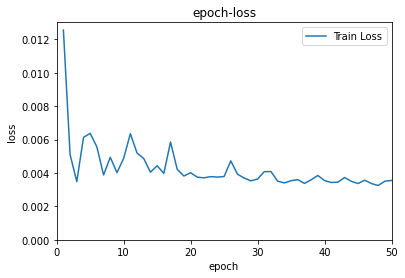

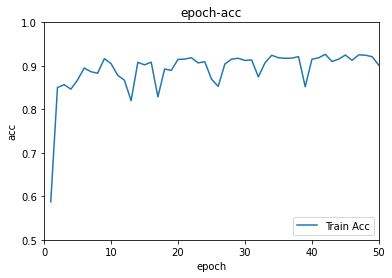

In [12]:
# Visualization
epochs = 50
l = np.array(history.history['loss'])
a = np.array(history.history['accuracy'])
step = np.linspace(1,epochs,epochs)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, epochs))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('../docs/ESPCN/train-loss.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, epochs))
plt.ylim((0.5, 1))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('../docs/ESPCN/train-acc.png', bbox_inches='tight')
plt.show()

In [11]:
espcn.save_weights("./model/ESPCN")